In [15]:
# Enable current type hints for older Python version (<3.10) 
from __future__ import annotations
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

In [16]:
from dotenv import dotenv_values

config = dotenv_values(".env")  # config = {"USER": "foo", "EMAIL": "foo@example.org"}

BUCKET_NAME = config['BUCKET_NAME']
PREFIX = config['PREFIX']
FILE_NAME = config['FILE_NAME']
TRAINING_DATA_PATH = config['TRAINING_DATA_PATH']
VALIDATION_DATA_PATH = config['VALIDATION_DATA_PATH']

In [17]:
# Todo: Remove this once using feature store
import pickle
with open('df_test.pickle', 'rb') as f:
    df_test: pd.DataFrame = pickle.load(f)

In [18]:
import sagemaker

role = sagemaker.get_execution_role()
region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print(f"Using SageMaker BlazingText container: {container} ({region_name})")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1 (us-east-1)


In [19]:
def create_model_inputs(input_path_train, input_path_val):
    train_data = sagemaker.inputs.TrainingInput(
        f's3://{input_path_train}',
        distribution="FullyReplicated",
        content_type="text/plain",
        s3_data_type="S3Prefix",
    )
    validation_data = sagemaker.inputs.TrainingInput(
        f's3://{input_path_val}',
        distribution="FullyReplicated",
        content_type="text/plain",
        s3_data_type="S3Prefix",
    )
    data_channels = {"train": train_data, "validation": validation_data}
    return data_channels


# data_channels_base = create_model_inputs(train_path_base, val_path_base)
data_channels = create_model_inputs(input_path_train=TRAINING_DATA_PATH, input_path_val=VALIDATION_DATA_PATH)

In [28]:
from sagemaker.serializers import JSONSerializer
def train_and_deploy(inputs):
    est = sagemaker.estimator.Estimator(
        container,
        role,
        instance_count=1,
        instance_type="ml.c4.4xlarge",
        volume_size=30,
        max_run=360000,
        input_mode="File",
        output_path=output_path,
        hyperparameters={
            "mode": "supervised",
            "epochs": 3,
            "min_count": 2,
            "learning_rate": 0.05,
            "vector_dim": 100,
            "early_stopping": True,
            "patience": 4,
            "min_epochs": 5,
            "word_ngrams": 2,
        },
    )
    est.fit(inputs=data_channels, logs=True)# using the same nltk tokenizer that we used during data preparation for training

    deployed_model = est.deploy(
        initial_instance_count=1, instance_type="ml.m5.xlarge", serializer=JSONSerializer()
    )
    return est, deployed_model

_, deployed_model = train_and_deploy(inputs=data_channels)

2022-10-14 10:06:51 Starting - Starting the training job...
2022-10-14 10:07:21 Starting - Preparing the instances for trainingProfilerReport-1665742011: InProgress
.........
2022-10-14 10:08:41 Downloading - Downloading input data...
2022-10-14 10:09:22 Training - Training image download completed. Training in progress.Arguments: train
[10/14/2022 10:09:06 WARNING 140082370721600] Loggers have already been setup.
[10/14/2022 10:09:06 WARNING 140082370721600] Loggers have already been setup.
[10/14/2022 10:09:06 INFO 140082370721600] nvidia-smi took: 0.05026745796203613 secs to identify 0 gpus
[10/14/2022 10:09:06 INFO 140082370721600] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[10/14/2022 10:09:06 INFO 140082370721600] Processing /opt/ml/input/data/train/input-blazing-text.csv . File size: 78.67445850372314 MB
[10/14/2022 10:09:06 INFO 140082370721600] Processing /opt/ml/input/data/validation/input-blazing-text.

## Prediction
### Make predictions
Let's get the test data and get the associated predictions from the Sagemaker endpoint we deployed in the previous step.

In [24]:
import json

# Save as np array for easy splitting later
replied_tos = df_test.loc[df.target == '__label__reply', 'feature'].values
no_reply = df_test.loc[df.target == '__label__no_reply', 'feature'].values

In [38]:
def _prediction_to_df_row(pred: dict) -> dict:
    labels = pred['label']
    probs = pred['prob']
    return {
        label: prob 
        for label, prob in zip(labels, probs)
    }

def get_probs(text: np.array, deployed_model) -> list[np.float]:
    payload = {
        "instances": text,
        "configuration": {"k": 2},  # get probs for top-k (both) classes
    }
    response = deployed_model.predict(payload)
    predictions = json.loads(response)

    all_probs = [
        _prediction_to_df_row(pred) for pred in predictions
    ]
    return pd.DataFrame(all_probs)['__label__reply']

p_reply = get_probs(replied_tos, deployed_model=deployed_model)
p_reply.describe()


count    43.000000
mean      0.581925
std       0.281160
min       0.018831
25%       0.380132
50%       0.571513
75%       0.795249
max       0.999826
Name: __label__reply, dtype: float64

In [41]:
# Need to make 2 requests
p_no_reply = pd.concat(
    [
        get_probs(no_reply[:2000], deployed_model=deployed_model),
        get_probs(no_reply[2000:], deployed_model=deployed_model)
    ],
    axis=0
)
p_no_reply.describe()

count    3632.000000
mean        0.139382
std         0.208497
min         0.000010
25%         0.011663
50%         0.036616
75%         0.173670
max         0.995345
Name: __label__reply, dtype: float64

### Model performance

In [63]:
# Vectors of true and predicted scores
y_true = [1] * len(replied_tos) + [0] * len(no_reply)
y_score = p_reply.append(p_no_reply)

y_score.describe()

count    3675.000000
mean        0.144560
std         0.214782
min         0.000010
25%         0.011915
50%         0.037556
75%         0.188007
max         0.999826
Name: __label__reply, dtype: float64

In [64]:
# AUC
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
roc_auc_score(y_true=y_true, y_score=y_score)

0.8985567564798689

The AUC of .9 is pretty good, but  it can be misleading for an imbalanced classification problem (remember, we only oversampled the training and validation data). Thus, let's look at the confusion matrix for a more detailed view.

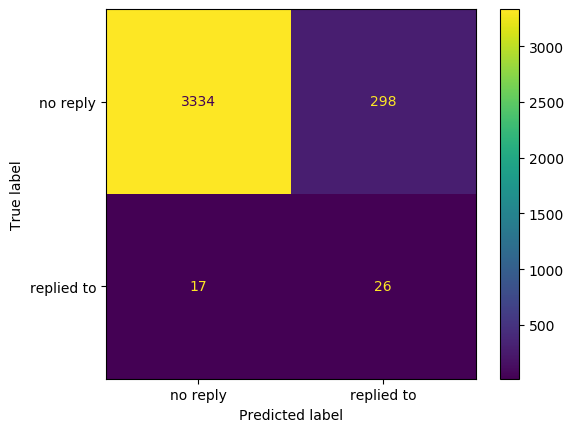

In [75]:
cm = confusion_matrix(y_true=y_true, y_pred=y_score>0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no reply', 'replied to'])
disp = disp.plot()
plt.show()

We see that if we just predict the most probable class, we can correctly predict about 60% of replies. This is pretty good for predicting a rare event. Depending on what we care about, we could adjust the prediction threshold. For example, if we care about identifying messages that could potentially require a reply, we could flag each message that has a probability of reply greater than 10%. Let's see what results this gives us:

In [60]:
print(
    classification_report(y_true=y_true, y_pred=y_score>0.5, target_names=['no reply', 'replied to'])
)

              precision    recall  f1-score   support

    no reply       0.99      0.92      0.95      3632
  replied to       0.08      0.60      0.14        43

    accuracy                           0.91      3675
   macro avg       0.54      0.76      0.55      3675
weighted avg       0.98      0.91      0.95      3675



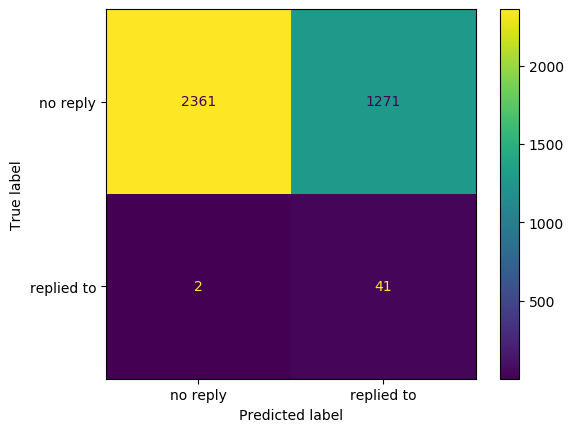

In [76]:
cm = confusion_matrix(y_true=y_true, y_pred=y_score>0.1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no reply', 'replied to'])
disp = disp.plot()
plt.show()

In [77]:
print(
    classification_report(y_true=y_true, y_pred=y_score>0.1, target_names=['no reply', 'replied to'])
)

              precision    recall  f1-score   support

    no reply       1.00      0.65      0.79      3632
  replied to       0.03      0.95      0.06        43

    accuracy                           0.65      3675
   macro avg       0.52      0.80      0.42      3675
weighted avg       0.99      0.65      0.78      3675



Now we are able to identify almost all emails eliciting a reply, at the cost of more false positives.

In [ ]:
sess.delete_endpoint(deployed_model)

In [ ]:
from datetime import datetime
print(f'Finished at {datetime.now()}')